# Digital Image Processing - HW13 - 98722278 - Mohammad Doosti Lakhani
In this notebook, I have solved the assignment's problems which are as follows:

1. Answer below questions:
    1. What is **Dilated Convolution**? 
    2. What are use cases?
    3. What are Pros and Cons?
2. Mask R-CNN:
    1. Report a summary of [Mask R-CNN](http://openaccess.thecvf.com/content_ICCV_2017/papers/He_Mask_R-CNN_ICCV_2017_paper.pdf) paper.
    2. Use any implemented model(pretrained) on your custom input
3. Compute number of parameters *in each layer* for below network:

``` python
model = get_unet((256, 256, 3))
def conv2d_block(input_tensor, n_filters, kernel_size=3):
 
 # first layer
 x=Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
 padding='same')(input_tensor)
 x=Activation('relu')(x)
 # second layer
 x=Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
 padding='same')(input_tensor)
 x=Activation('relu')(x)
 return x
def get_unet(input_img, n_filters=16):
 # Contracting Path
 c1=conv2d_block(input_img, n_filters*1, kernel_size=3)
 p1=MaxPooling2D((2, 2))(c1)

 c2=conv2d_block(p1, n_filters*2, kernel_size=3)
 p2=MaxPooling2D((2, 2))(c2)
 
 c3=conv2d_block(p2, n_filters*4, kernel_size=3)
 p3=MaxPooling2D((2, 2))(c3)

 c4=conv2d_block(p3, n_filters*8, kernel_size=3)
 p4=MaxPooling2D((2, 2))(c4)

 c5=conv2d_block(p4, n_filters=n_filters*16, kernel_size=3)

 # Expansive Path
 u6=Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)
 u6=concatenate([u6, c4])
 c6=conv2d_block(u6, n_filters*8, kernel_size=3)
 u7=Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)
 u7=concatenate([u7, c3])

 c7=conv2d_block(u7, n_filters*4, kernel_size=3)
 u8=Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)
 u8=concatenate([u8, c2])
 c8=conv2d_block(u8, n_filters*2, kernel_size=3)
 u9=Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)
 u9=concatenate([u9, c1])
 c9=conv2d_block(u9, n_filters*1, kernel_size=3)
 outputs=Conv2D(10, (1, 1), activation='sigmoid')(c9)
 model=Model(inputs=[input_img], outputs=[outputs])
 return model


```

## 1 Answer below questions:
1. What is **Dilated Convolution**? 
2. What are use cases?
3. What are Pros and Cons?

### 1.A Dilated Convolutation
First of of let depict the whole idea simply by comparing the dilated convolution math formual and standard conv formula.

![dilated conv](wiki/1_1.png)

As we can see hyper parameter has been added which is `l` where corresponds to number of steps per addition in long-run convolution. If we set `l=0`, then we have normal convolution. This parameter `l` will skip some points in enighborhood.

Here is how it works:

![dilated conv vis](wiki/1_2.gif)

Dilated convolution incorporates larger receptive field regarding same amount of parameters of windows size, etc regarding normal conv.

![dilated conv receptive field](wiki/1_3.png)

### 1.B Use cases
In the paper [Multi-scale contex aggregation by dilated convolutions](http://vladlen.info/papers/dilated-convolutions.pdf) authors have shown that almost any model on **semantic segmentation** task can perform better by adding a `contex` layer which is constructed of multiple different conv layers with different size of `l` to intorduce bigger receptive field over layers.

The reason is as we know in semantic segmentation of similar tasks, we need to consider different object sizes when labeling pixels, so by having normal conv (`l=1`) and adding dilated convs (`l>=2`), the receptive field has been increased so labeling can be done wiser.

Here is the definition of `contex` module in the aforementioned paper:

![context module](wiki/1_4.png)

### 1.C Pros and Cons
About pros, in summary we can say dilation does not change number of parameters or calculations, so there is no memory of time disadvantage about this operation but as this approach provides larger receptive fields regarding same amount of operations, it outperforms must of the base models. Also, it dilation factor can be increased while preserving resolution. All this aspects caused to have better results in semantic segmentation tasks.

But about cons, using dilation in models such as ResNet where this models try to preserve learned features in previous layers, can cause producing artifacts like chess board or dot effect in image-to-image translation tasks. Although this problem has solved by adding skip-connections to some particular points, not all x-step convs.

## 2 Mask R-CNN:
1. Report a summary of [Mask R-CNN](http://openaccess.thecvf.com/content_ICCV_2017/papers/He_Mask_R-CNN_ICCV_2017_paper.pdf) paper.
2. Use any implemented model(pretrained) on your custom input

### 2.A Mask R-CNN
Let's say firstly we know what is object detection, semantic segmentation and instance segmentation. (See [here](https://github.com/Nikronic/Digital-Image-Processing-IUST/tree/master/HW11#1-compare-semantic-segmentation-object-detection-and-instance-segmentation) if not) 

Also let's say we know what *R-CNN*, *Fast R-CNN* and *Faster R-CNN* models are. (See [here](https://github.com/Nikronic/Digital-Image-Processing-IUST/tree/master/HW11#2-compare-rcnn-fast-rcnn-and-faster-rcnn) if not)

Mask R-CNN is a model for instance segmentation task. 
This model generate 3 outputs :
1. Object label
2. Bounding box
3. Object mask

About all previous models with R-CNN architecture, third output has been provided and actually the major importance of Mask R-CNN model because third output. 

*Now let's have a brief understanding of model before going into more details.*

![mask r-cnn model](wiki/2_3.png)

Mask R-CNN has been constructed by two stages, first stage's duty is to generate region proposals but using completely different approach from previously proposed papers. Secondly, it generates object labels, refine boudning boxes and masks pixel-wise based on the region proposal from first stage. These both stages obtained from a base CNN model based on [Feature Pyramid Network](https://arxiv.org/abs/1612.03144) style.

FPN is U-net structure where in contracting phase any model like ResNet101 can be used. There is a expansion phase too which is similar to contracting phase but reverse in size where the output of each step in contracting phase has been concatenated to the output of corresponding layer in expansion phase. Here is image from FPN paper:

![fpn module](wiki/2_1.png)

![fpn module concat op](wiki/2_2.png)

Now let's talk about first stage. A small CNN model called RPN (region proposal network) will extract region candidate where objects may exists. This model uses the output of expansion phase of FPN model as input as these inputs are extracted features from input images given to the whole network. (This step is indentical to Faster R-CNN model)

But for second stage, Mask R-CNN generates a binary mask for each RoI while predicting object lables and their bounding boxes still is identical to faster r-cnn and have been done simultaneously.

The loss function also has been expanded to consider mask loss using weighted sum (for each RoI):

![loss mask rcnn](wiki/2_4.png)

Where loss bounding box and label are identical to faster rcnn.

The mask branch of network has `Km^2` output where consists of `K` layer with size of `m*m` where `K` is number of classes. So loss mask defines in the way that first apply per-pixel sigmoid then average binary cross-entropy.

Mask representation are small vectors which have been obtained from fully connected layers. The structure of spatial features of masks can be gained by pixel-to-pixel measurements. So to do this, authors generate `m*m` masks for each RoI using an FCN. But features from different RoIs need to be well aligned to be correctly measured using pixel-to-pixel approach and that's why **RoIAlign** has been introduced.

**RoIAlgin** is operation to extract a small feature map from a RoI. But how it works:
1. Use RoIPool to quantize a floating-point RoI into discrete form (`round(x/16)`)
2. Divine output into different spatial bins where all are quantized too
3. Aggregate feature values covered by each bin using MaxPool

This approach introduces misaligned bins for different RoIs so to handle this harsh quantization, **RoIAlgin** layer has been used. To solve this issue here is the new approach:

1. Use `x/16` (no rounding) to quantize
2. Consider four bins for each RoI
3. Fill missed values using bilinear interpolation
4. Aggregate feature values using MaxPool or AvgPool

And about network architecture, three term can represent it:
1. **Backbone** where can be any FPN network or VGG style used for feature extraction
2. **Head** network for bounding box prediction and mask generationg where applied *separately* where can be any fully convolutional network like a part of ResNet, etc.



### 2.B Mask R-CNN Inference

In [5]:
!git clone https://github.com/matterport/Mask_RCNN.git
cd Mask_RCNN/

/content/Mask_RCNN


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
%tensorflow_version 1.x

In [ ]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from samples.coco import coco

In [ ]:
MODEL_DIR = 'mask_rcnn_coco.h5'
if not os.path.exists(MODEL_DIR):
    utils.download_trained_weights(MODEL_DIR)

In [16]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
model = modellib.MaskRCNN(mode="inference", model_dir='logs', config=config)
model.load_weights(MODEL_DIR, by_name=True)

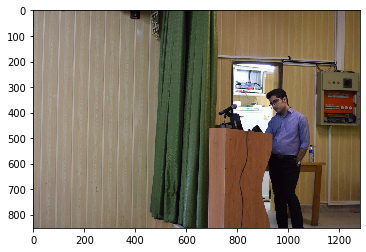

In [21]:
file_name = '../conf.jpg'
image = skimage.io.imread(file_name)
plt.imshow(image)

Processing 1 images
image                    shape: (852, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


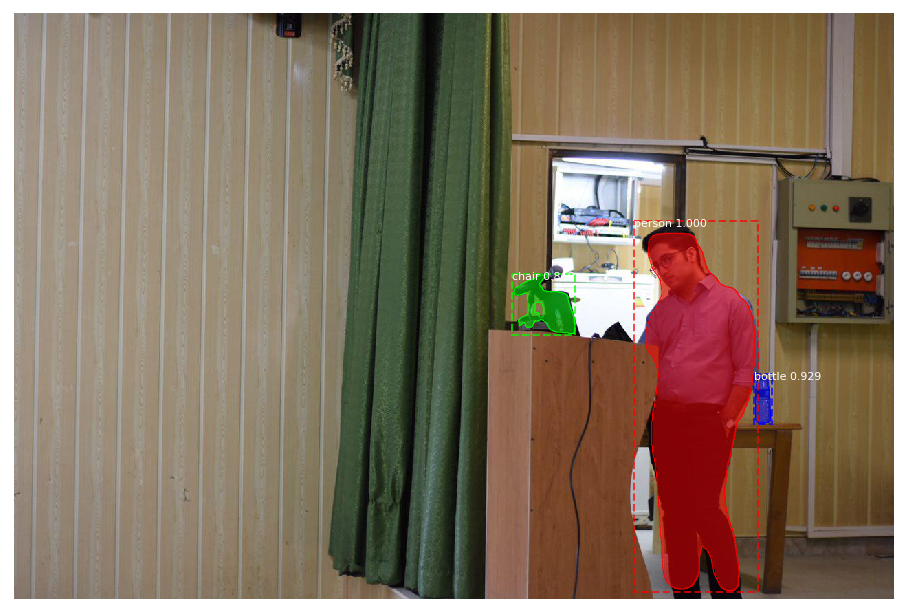

In [22]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

*Note: README: The code has been run on Colab*

## 3 Compute number of parameters *in each layer* for below network:

``` python
model = get_unet((256, 256, 3))
def conv2d_block(input_tensor, n_filters, kernel_size=3):
 
 # first layer
 x=Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
 padding='same')(input_tensor)  # Block_{changes with 'c' layers}_1
 x=Activation('relu')(x)
 # second layer
 x=Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
 padding='same')(input_tensor)  # Block_{changes with 'c' layers}_2
 x=Activation('relu')(x)
 return x
def get_unet(input_img, n_filters=16):
 # Contracting Path
 c1=conv2d_block(input_img, n_filters*1, kernel_size=3)  # c1
 p1=MaxPooling2D((2, 2))(c1)

 c2=conv2d_block(p1, n_filters*2, kernel_size=3)  # c2
 p2=MaxPooling2D((2, 2))(c2)
 
 c3=conv2d_block(p2, n_filters*4, kernel_size=3)  # c3
 p3=MaxPooling2D((2, 2))(c3)

 c4=conv2d_block(p3, n_filters*8, kernel_size=3)  # c4
 p4=MaxPooling2D((2, 2))(c4)

 c5=conv2d_block(p4, n_filters=n_filters*16, kernel_size=3)  # c5

 # Expansive Path
 u6=Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same')(c5)  # u6
 u6=concatenate([u6, c4])
 c6=conv2d_block(u6, n_filters*8, kernel_size=3)  # c6
 u7=Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same')(c6)  # u7
 u7=concatenate([u7, c3])

 c7=conv2d_block(u7, n_filters*4, kernel_size=3)  # c7
 u8=Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same')(c7)  # u8
 u8=concatenate([u8, c2])
 c8=conv2d_block(u8, n_filters*2, kernel_size=3)  # c8
 u9=Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same')(c8)  # u9
 u9=concatenate([u9, c1])
 c9=conv2d_block(u9, n_filters*1, kernel_size=3)  #c9
 outputs=Conv2D(10, (1, 1), activation='sigmoid')(c9)  # outputs
 model=Model(inputs=[input_img], outputs=[outputs])
 return model


First please the comments above the understand naming convention used in below table of number of paramteres demonstration.

| Layer Name | # Params |
| --- | --- |
| block_c1_1 | 448 |
| block_c1_2 | 2320 |
| block_c2_1 | 4640 |
| block_c2_2 | 9248 |
| block_c3_1 | 18496 |
| block_c3_2 | 36928 |
| block_c4_1 | 73856 |
| block_c4_2 | 147584 |
| block_c5_1 | 295168 |
| block_c5_2 | 590080 |
| u6 | 295040 |
| block_c6_1 | 295040 |
| block_c6_2 | 147584 |
| u7 | 73792 |
| block_c7_1 | 73792 |
| block_c7_2 | 36928 |
| u8 | 18464 |
| block_c8_1 | 18464 |
| block_c8_2 | 9248 |
| u9 | 4624 |
| block_c9_1 | 4624 |
| block_c9_2  | 2320 |
| outputs | 170 |